In [1]:
'''
Forward projection followed by reconstruction. Using the step-and-shoot conebeam model.
'''

'\nForward projection followed by reconstruction. Using the step-and-shoot conebeam model.\n'

In [2]:
import os

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import pcct_md_diffusion.utils as utils

from pcct_md_diffusion.fbp import additional_neurologica_filter
from pcct_md_diffusion.locations import base_input_dir

In [3]:
geo_filename = os.path.join(base_input_dir, 'omnitom_pcd/geometry/omnitom_3x3_fan_fov_252.cfg')
img_dir = os.path.join(base_input_dir, 'omnitom_pcd/recon/img/44/')
neurologica_filter_name = os.path.join(base_input_dir, 'omnitom_pcd/geometry/kernels/3x3/kern1')

In [4]:
img, dx, dy, dz = utils.load_image(img_dir)
# convert to attenuation coefficients
img = (img + 1000) / 1000 * 0.02
img[img < 0] = 0
img = img.astype(np.float32)

print(f'Loaded image with shape {img.shape}, dx={dx}, dy={dy}, dz={dz}')

Loading channel 0...
Loading channel 1...
Loading channel 2...
Loaded image with shape (3, 221, 512, 512), dx=0.4921875, dy=0.4921875, dz=0.8479999899864197



======== CT Cone-Beam Geometry (curved detector) ========
number of angles: 1440
number of detector elements (rows, cols): 1 x 896
angular range: 360.000000 degrees
detector pixel size: 0.848000 mm x 0.572500 mm
center detector pixel: 0.000000, 455.690002
sod = 366.000000 mm
sdd = 596.000000 mm
tiltAngle = 0.000000 degrees

======== CT Volume ========
number of voxels (x, y, z): 512 x 512 x 1
voxel size: 0.492188 mm x 0.492188 mm x 0.848000 mm
FOV: [-126.000000, 126.000000] x [-126.000000, 126.000000] x [-0.424000, 0.424000]

======== Processing Settings ========
GPU processing on device 0
GPU with least amount of memory: 34.791451 GB



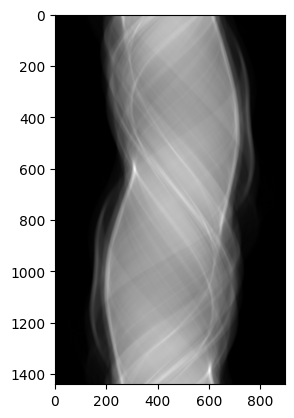

In [5]:
geo = utils.load_geometry(geo_filename)
geo.dx = dx
geo.dy = dy
geo.dz = dz
geo.dv = dz
geo.nv = 1
geo.nx = img.shape[-1]
geo.ny = img.shape[-2]
geo.nz = 1

leapct = utils.set_leapct_geometry(geo, utils.GeometryType.CONE_CURVED)
leapct.print_parameters()
proj = leapct.allocate_projections()

projs = []
for islice in range(img.shape[1]):
    img_slice = np.copy(img[0, [islice]], 'C')
    leapct.project(proj, img_slice)
    projs.append(np.copy(proj))
projs = np.concatenate(projs, axis=1)

plt.imshow(projs[:, projs.shape[1]//2, :], cmap='gray')

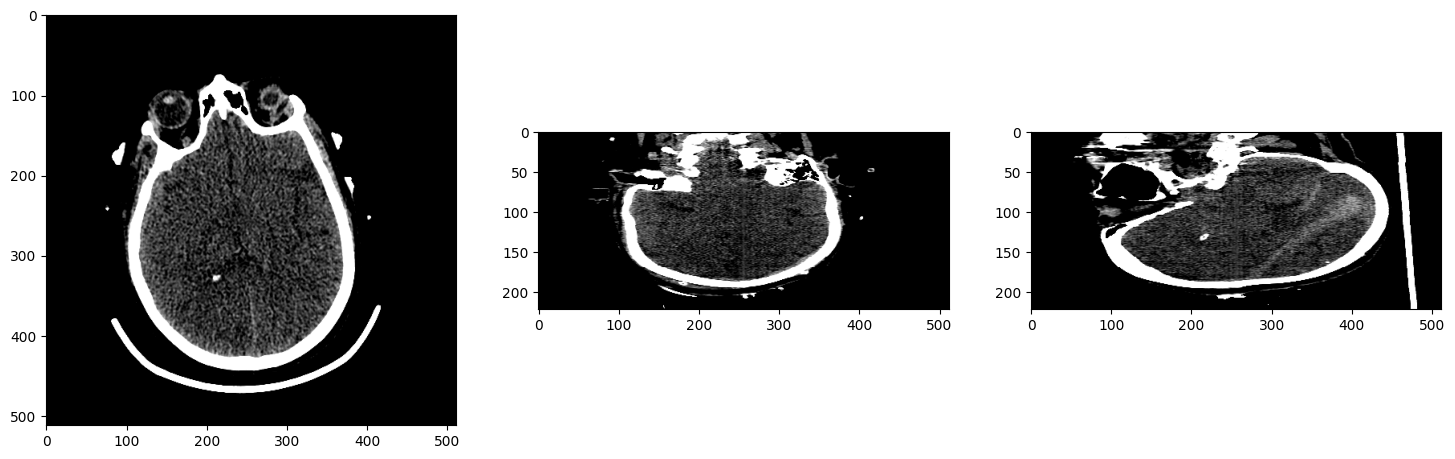

In [6]:
# noiseless FBP
recons = []
for islice in range(projs.shape[1]):
    proj_slice = np.copy(projs[:, [islice]], 'C')
    recon = leapct.FBP(proj_slice)
    recons.append(np.copy(recon))
fbp_noiseless = np.concatenate(recons, axis=0)

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(fbp_noiseless[fbp_noiseless.shape[0] // 2, :, :], cmap='gray', vmin=0.02, vmax=0.022)
plt.subplot(132)
plt.imshow(fbp_noiseless[:, fbp_noiseless.shape[1] // 2, :], cmap='gray', vmin=0.02, vmax=0.022)
plt.subplot(133)
plt.imshow(fbp_noiseless[:, :, fbp_noiseless.shape[2] // 2], cmap='gray', vmin=0.02, vmax=0.022)

In [7]:
# add some noise
N0 = 5e5
dose_factor = 0.25

noisy_projs = utils.add_noise_gaussian(projs, N0=N0, dose_factor=dose_factor)

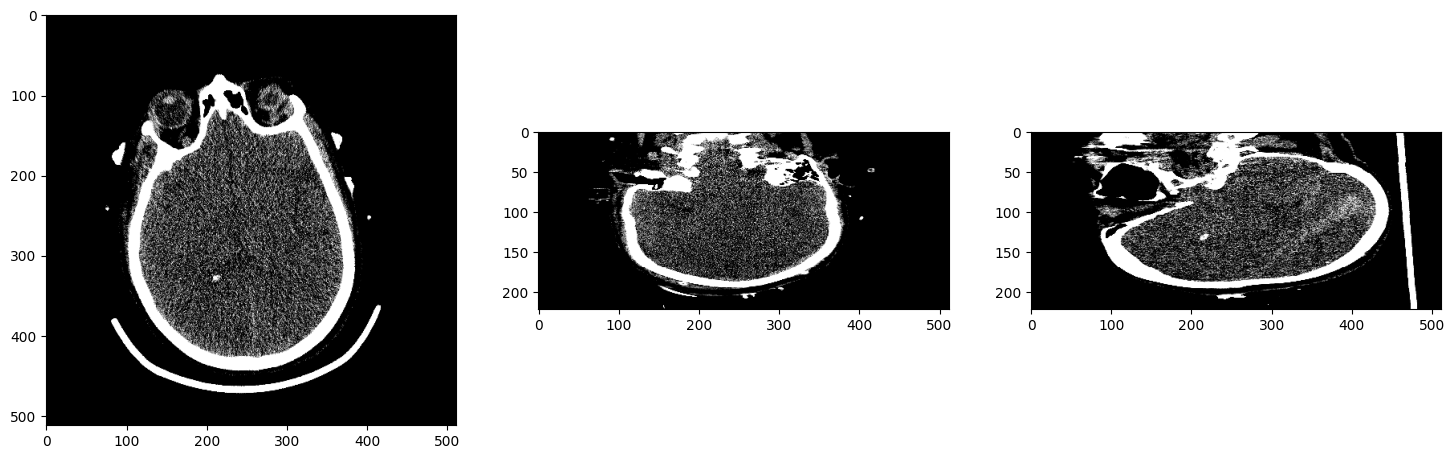

In [8]:
# FBP with Ramp filter
recons = []
for islice in range(noisy_projs.shape[1]):
    proj_slice = np.copy(noisy_projs[:, [islice]], 'C')
    recon = leapct.FBP(proj_slice)
    recons.append(np.copy(recon))
fbp_noisy_ramp = np.concatenate(recons, axis=0)

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(fbp_noisy_ramp[fbp_noisy_ramp.shape[0] // 2, :, :], cmap='gray', vmin=0.02, vmax=0.022)
plt.subplot(132)
plt.imshow(fbp_noisy_ramp[:, fbp_noisy_ramp.shape[1] // 2, :], cmap='gray', vmin=0.02, vmax=0.022)
plt.subplot(133)
plt.imshow(fbp_noisy_ramp[:, :, fbp_noisy_ramp.shape[2] // 2], cmap='gray', vmin=0.02, vmax=0.022)

In [9]:
# apply Neurologica filter to the noise
filtered_projs = additional_neurologica_filter(
    noisy_projs - projs, neurologica_filter_name, geo.du, geo.nview
)
noisy_projs_for_fbp = projs + filtered_projs

/users/PAS3128/wudufan33/Code/pcct/pcct_md_diffusion/src/pcct_md_diffusion/fbp/filters.py:87: RuntimeWarning: divide by zero encountered in divide
  rl_filter = -1 / (np.pi * np.pi * k * k * du2 * du2)


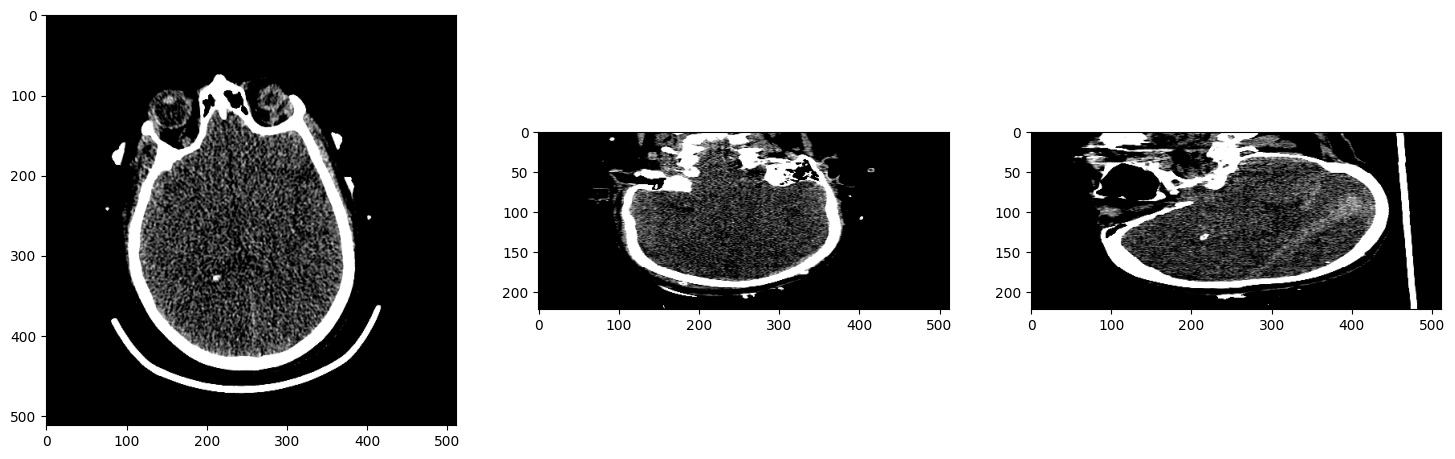

In [10]:
recons = []
for islice in range(noisy_projs_for_fbp.shape[1]):
    proj_slice = np.copy(noisy_projs_for_fbp[:, [islice]], 'C')
    recon = leapct.FBP(proj_slice)
    recons.append(np.copy(recon))
fbp_noisy_custom = np.concatenate(recons, axis=0)

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(fbp_noisy_custom[fbp_noisy_custom.shape[0] // 2, :, :], cmap='gray', vmin=0.02, vmax=0.022)
plt.subplot(132)
plt.imshow(fbp_noisy_custom[:, fbp_noisy_custom.shape[1] // 2, :], cmap='gray', vmin=0.02, vmax=0.022)
plt.subplot(133)
plt.imshow(fbp_noisy_custom[:, :, fbp_noisy_custom.shape[2] // 2], cmap='gray', vmin=0.02, vmax=0.022)